<a href="https://colab.research.google.com/github/dohyung-kim/ccri/blob/main/script/pixel/p1_normalization_pixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 120.0 MB/s eta 0:00:00


In [2]:
import shutil

src = "/content/drive/MyDrive/ccri_pixel"
dst = "/content/ccri_image"

shutil.copytree(src, dst)
print("Folder copied successfully!")


Folder copied successfully!


ASI_cropland_resampled.tif: Log Transformation and z-score Scaling - skew=-0.802, kurtosis=-0.554


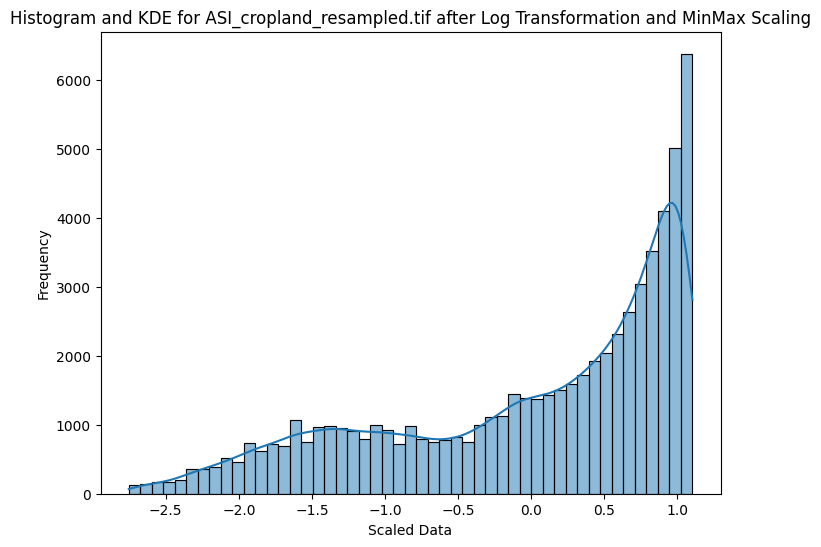

coastal_flood_mosaic.tif: Log Transformation and z-score Scaling - skew=2.166, kurtosis=3.628


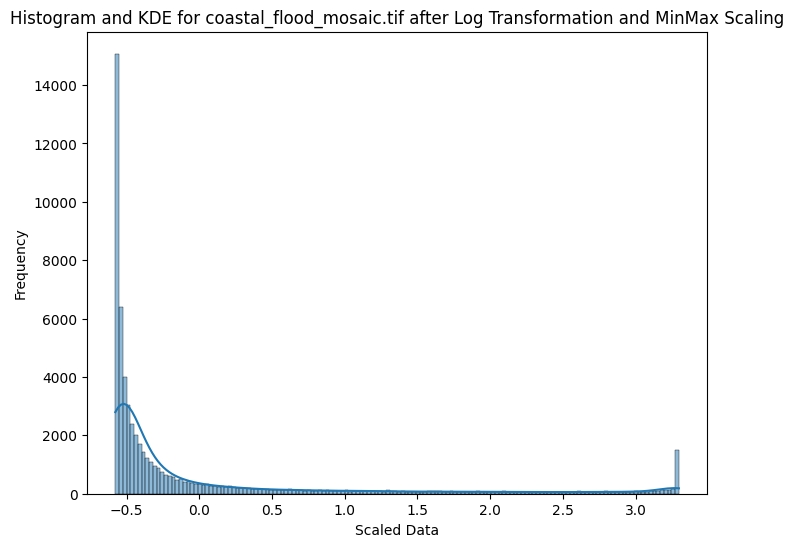

ERA5_100yr_RP_resampled.tif: Log Transformation and z-score Scaling - skew=0.363, kurtosis=-0.447


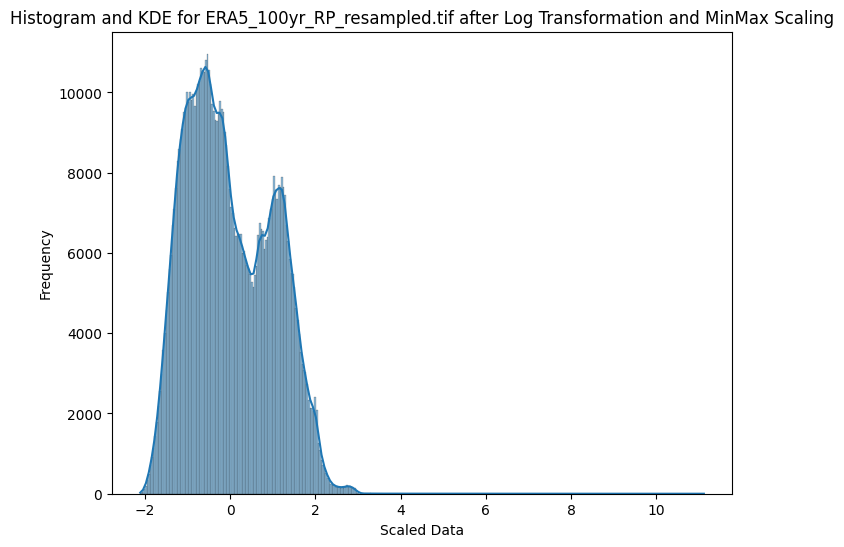

extreme_heat_days_resampled.tif: Log Transformation and z-score Scaling - skew=-0.231, kurtosis=-1.316


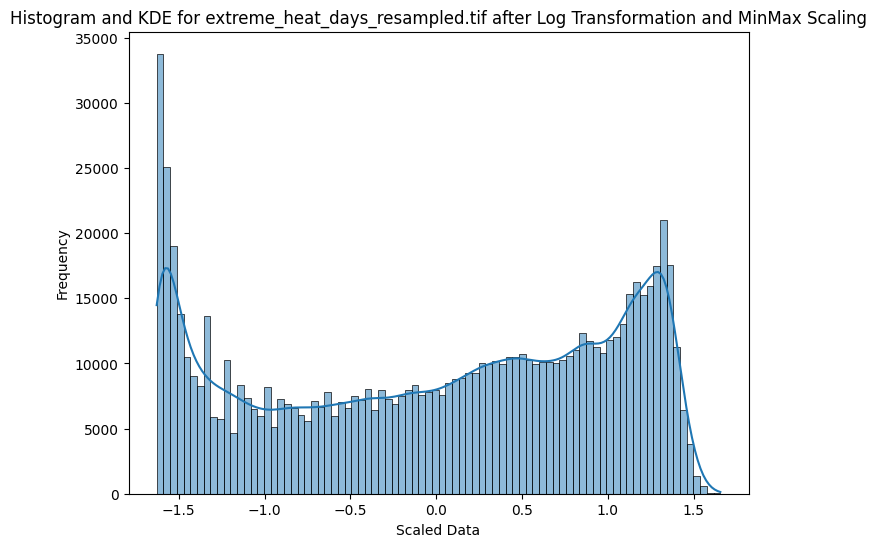

FIRMS_MODIS_Mean_Annual_Count_resampled.tif: Log Transformation and z-score Scaling - skew=1.095, kurtosis=0.859


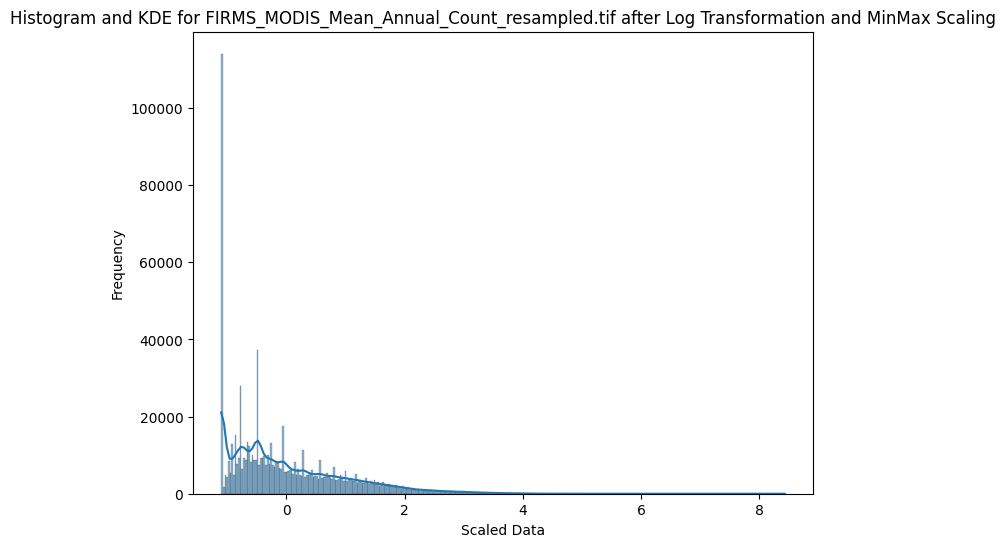

FIRMS_MODIS_Mean_Annual_FRP_2001_2023.tif: Log Transformation and z-score Scaling - skew=0.432, kurtosis=0.574


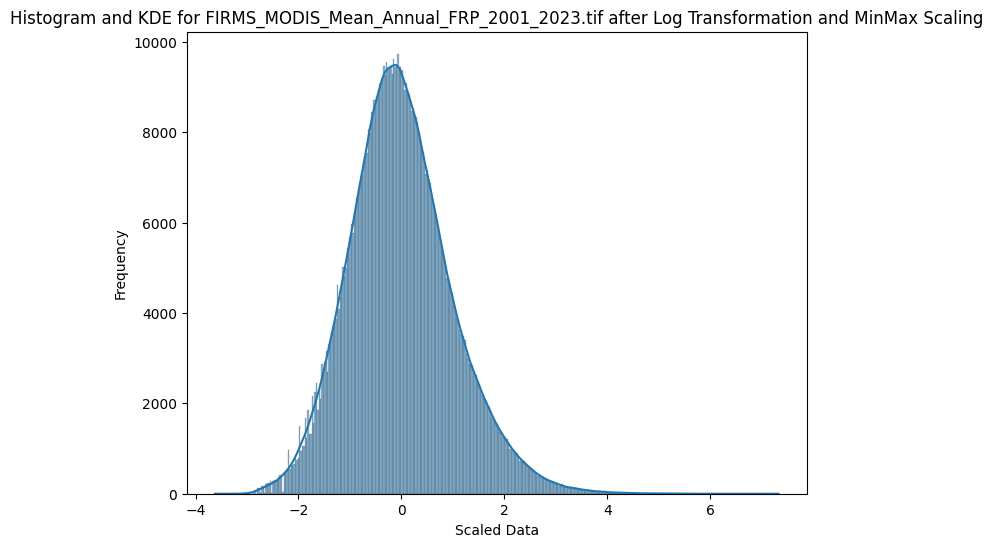

heatwave_duration_resampled.tif: Log Transformation and z-score Scaling - skew=0.626, kurtosis=1.305


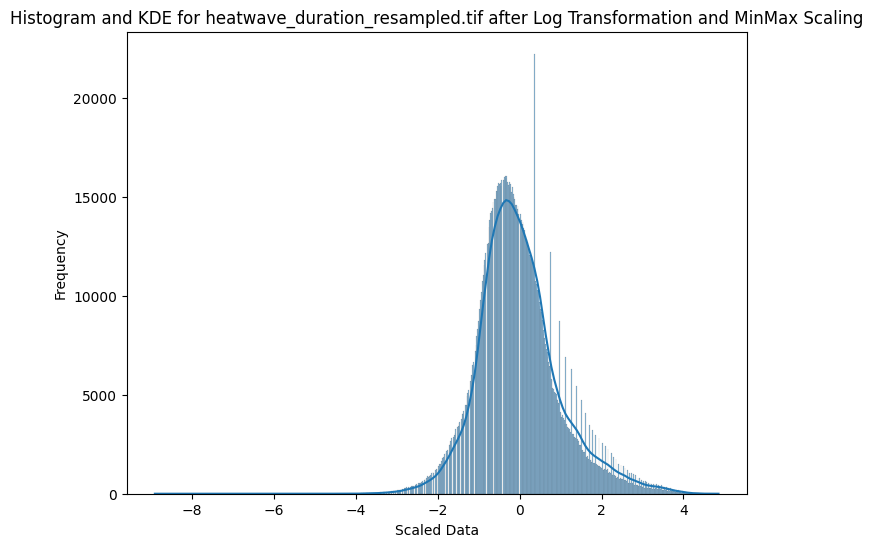

heatwave_frequency_resampled.tif: Log Transformation and z-score Scaling - skew=0.747, kurtosis=1.398


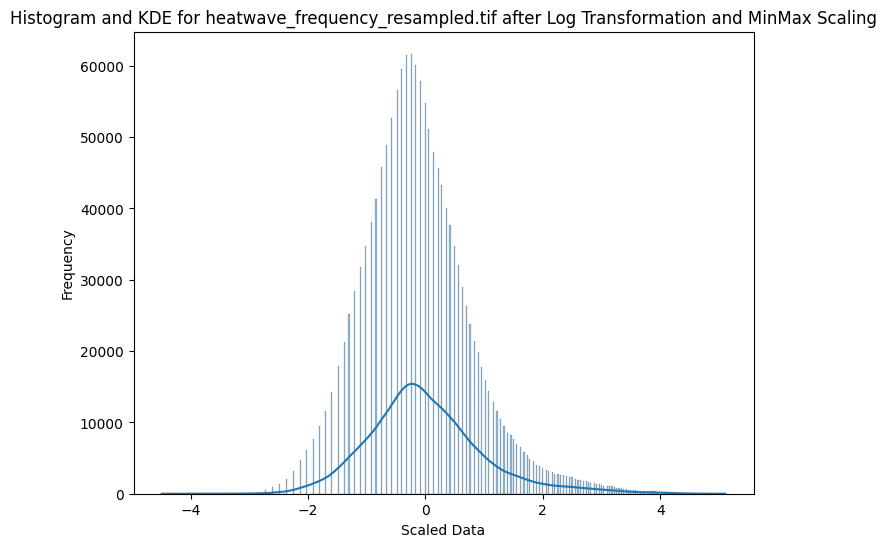

heatwave_severity_resampled.tif: Log Transformation and z-score Scaling - skew=-0.501, kurtosis=-0.590


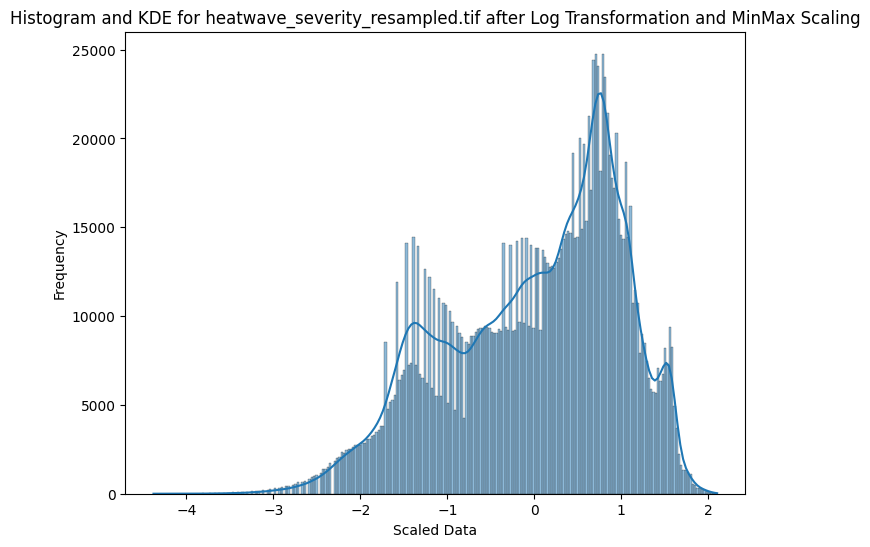

JBA_FLSW_resampled.tif: Log Transformation and z-score Scaling - skew=1.918, kurtosis=3.395


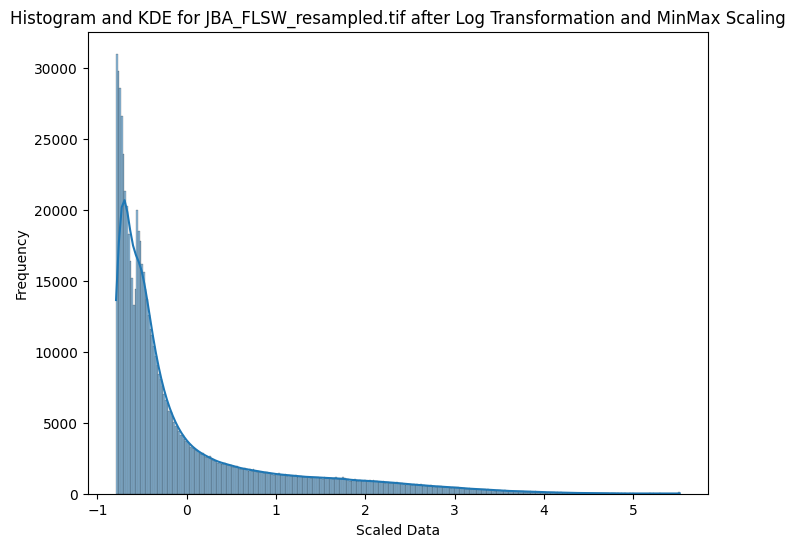

Pf_average_resampled.tif: Log Transformation and z-score Scaling - skew=0.855, kurtosis=-0.729


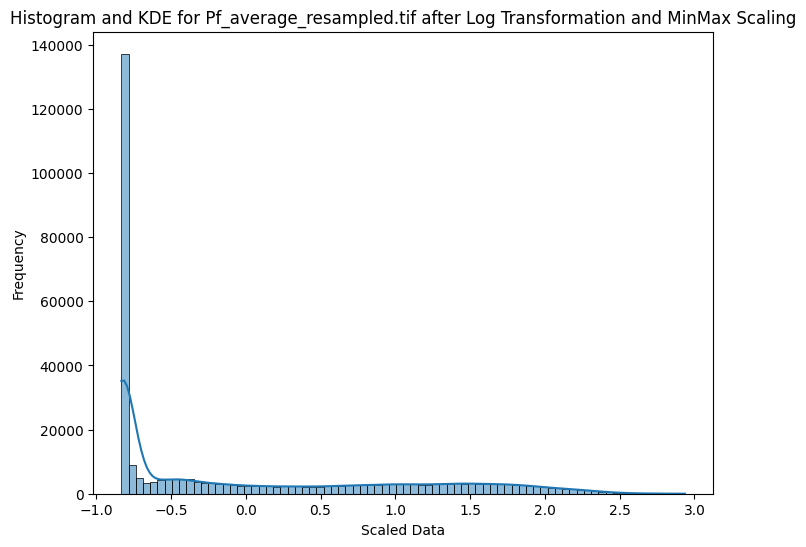

Pv_average_resampled.tif: Log Transformation and z-score Scaling - skew=2.498, kurtosis=6.597


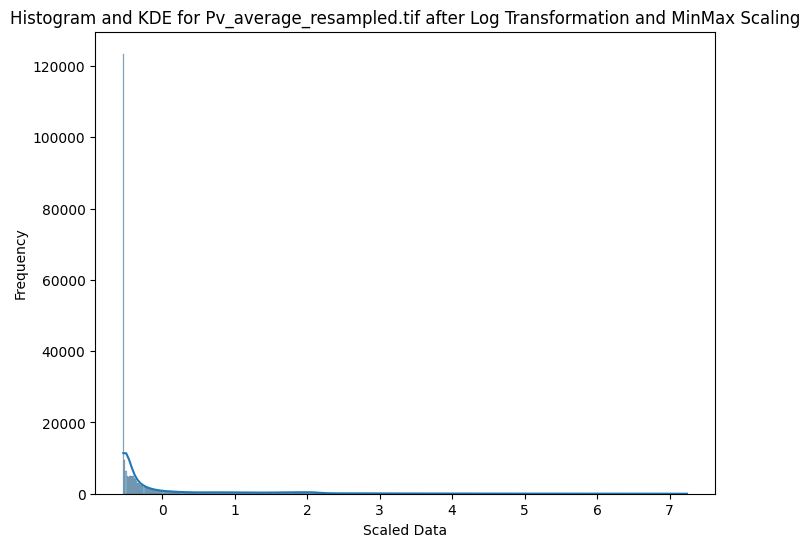

pm25_resampled.tif: Log Transformation and z-score Scaling - skew=0.060, kurtosis=-0.715


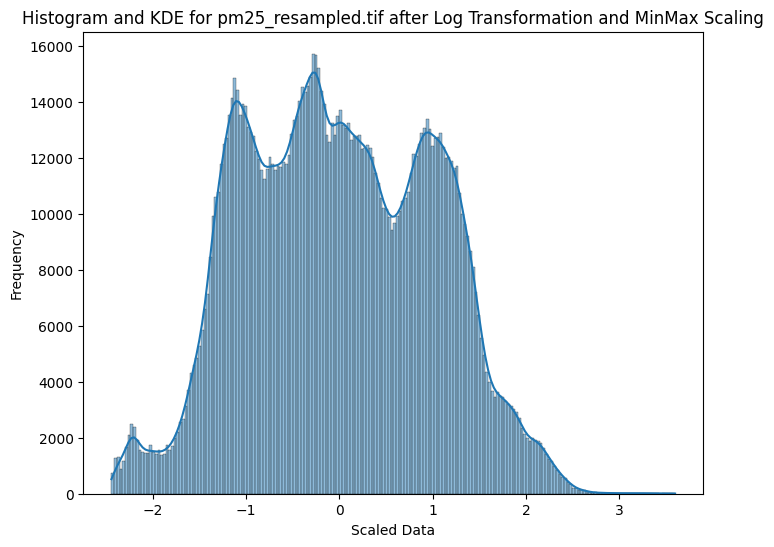

river_flood_mosaic.tif: Log Transformation and z-score Scaling - skew=0.890, kurtosis=0.644


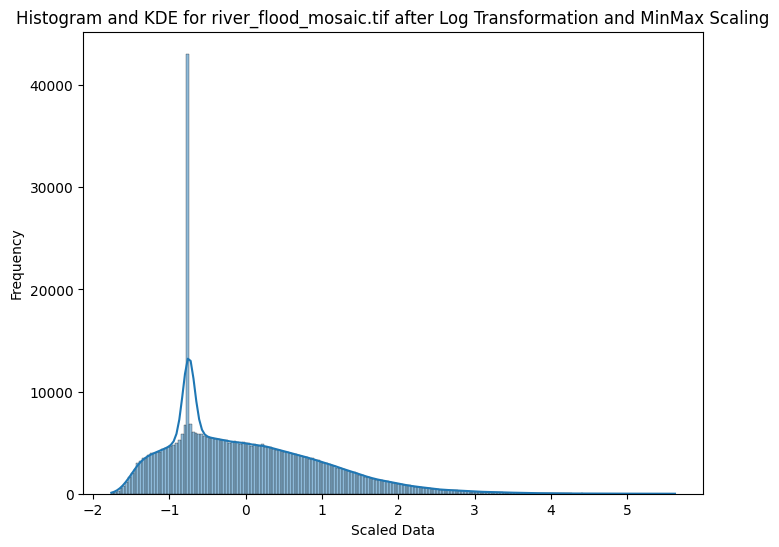

sand_dust_storm_resampled.tif: Log Transformation and z-score Scaling - skew=-0.119, kurtosis=-0.939


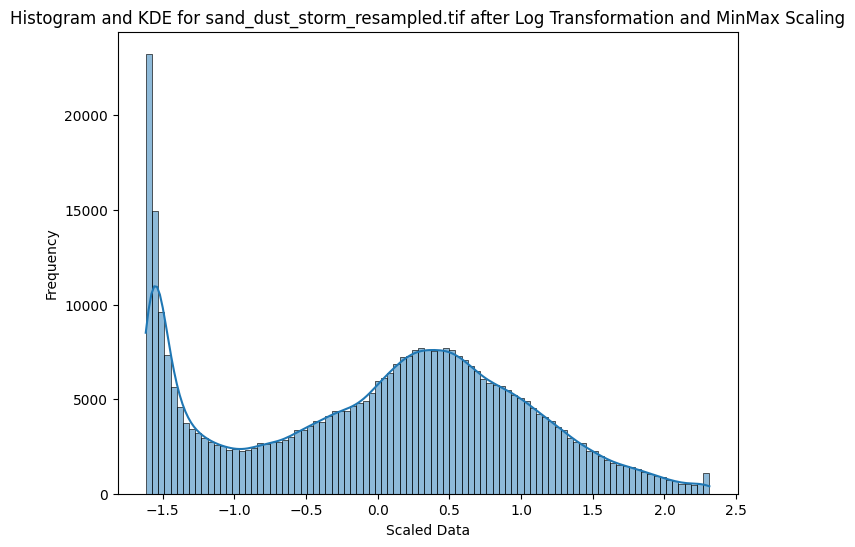

storm_mosaic.tif: Log Transformation and z-score Scaling - skew=0.481, kurtosis=-0.694


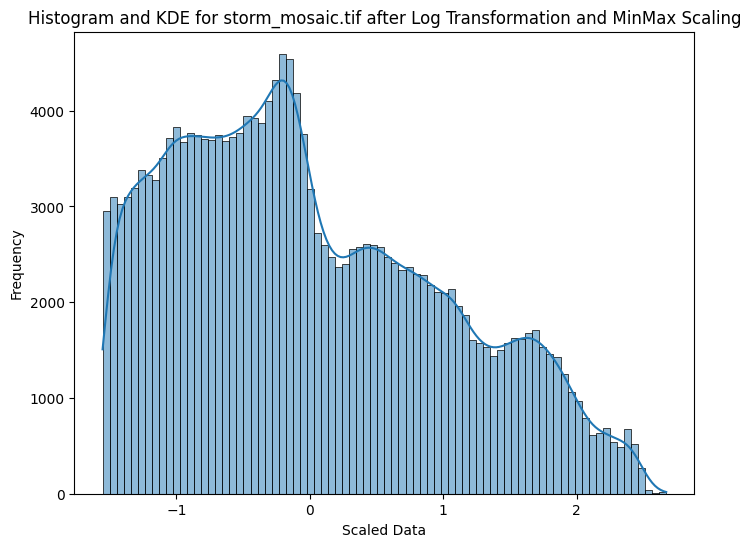

SPI_resampled.tif: Log Transformation and z-score Scaling - skew=0.545, kurtosis=-0.325


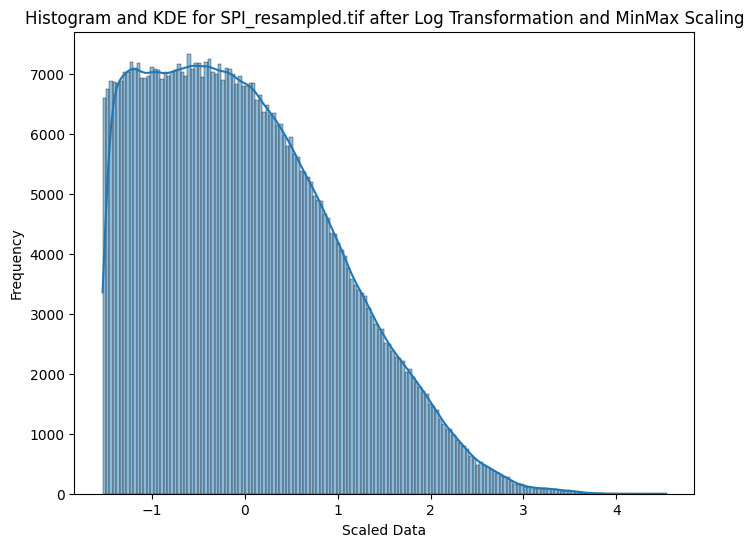

SMA_resampled.tif: Log Transformation and z-score Scaling - skew=0.902, kurtosis=0.764


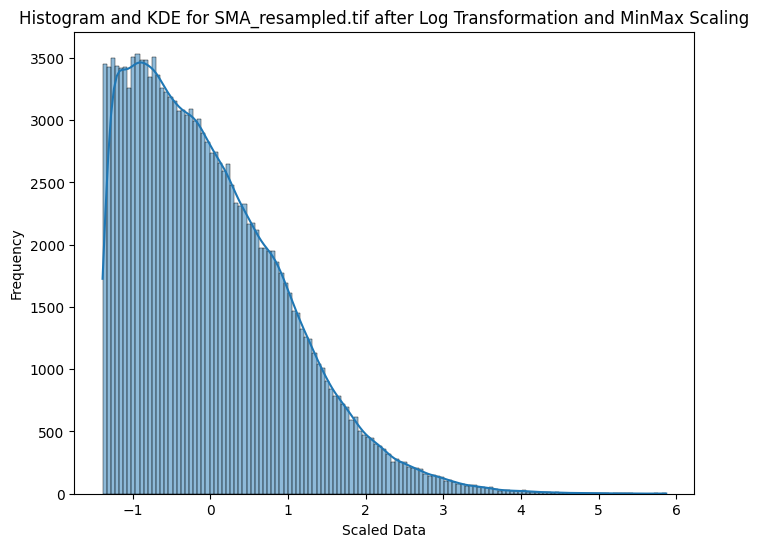

In [ ]:
import os
import numpy as np
import rasterio
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest, probplot
from scipy.stats import skew, kurtosis

# Define image folder and files
image_folder = dst
image_files = [
    "ASI_cropland_resampled.tif",
    "coastal_flood_mosaic.tif",  # Will be excluded from normalization
    "ERA5_100yr_RP_resampled.tif",
    "extreme_heat_days_resampled.tif",
    "FIRMS_MODIS_Mean_Annual_Count_resampled.tif",
    "FIRMS_MODIS_Mean_Annual_FRP_2001_2023.tif",
    "heatwave_duration_resampled.tif",
    "heatwave_frequency_resampled.tif",
    "heatwave_severity_resampled.tif",
    "JBA_FLSW_resampled.tif",
    "Pf_average_resampled.tif",
    "Pv_average_resampled.tif",
    "pm25_resampled.tif",
    "river_flood_mosaic.tif",
    "sand_dust_storm_resampled.tif",  # Will be excluded from normalization
    "storm_mosaic.tif",
    "SPI_resampled.tif",  # Special handling
    "SMA_resampled.tif"   # Special handling
]

# Load land-sea mask (1 = land, 0 = sea)
mask_path = os.path.join(image_folder, "landSeaMask.tif")
with rasterio.open(mask_path) as mask_src:
    landsea_mask = mask_src.read(1)  # Assuming single-band mask
    land_mask = landsea_mask == 1  # Boolean mask for land pixels

# Helper function to load images
def load_image(image_file):
    with rasterio.open(os.path.join(image_folder, image_file)) as src:
        data = src.read(1)  # Read the first band
        valid_data = np.where(land_mask, data, 0)  # Mask out sea area
        valid_data = np.nan_to_num(valid_data)  # Convert NaNs to zero
        return valid_data

# Load images and apply log transformation and MinMax scaling
scaler = StandardScaler()


def trim_outliers_iteratively(values, max_skew=2, max_kurtosis=3.5):
    """
    Iteratively removes extreme min/max values until skewness <= 2 and kurtosis <= 3.5.
    Returns the trimmed dataset along with the final min and max.
    """
    values_tmp = values.copy()  # Ensure no NaNs
    while True:
        current_skew = skew(values_tmp)
        current_kurtosis = kurtosis(values_tmp)

        if abs(current_skew) <= max_skew and current_kurtosis <= max_kurtosis:
            break  # Stop if conditions are met

        # Remove min and max values
        min_val, max_val = values_tmp.min(), values_tmp.max()
        values_tmp = values_tmp[(values_tmp > min_val) & (values_tmp < max_val)]  # Trim extreme min/max

    values = np.clip(values, values_tmp.min(), values_tmp.max())
    return values, values.min(), values.max()


for idx, image_file in enumerate(image_files):
    data = load_image(image_file)
    cleaned_data = data[~np.isnan(data)]  # Remove NaNs
    filtered_data = cleaned_data[cleaned_data > 0]  # Remove zeros and negatives

    if len(filtered_data) > 0:
        # Apply log transformation (log(1 + x) to avoid log(0))
        log_data = np.log1p(filtered_data)

        # Apply MinMax scaling to the log-transformed data
        log_data_scaled = scaler.fit_transform(log_data.reshape(-1, 1)).flatten()

        #get trimmed value
        trimmed_values, min_trimmed, max_trimmed = trim_outliers_iteratively(log_data_scaled)

        # Check normality using D'Agostino-Pearson test
        current_skew = skew(trimmed_values)
        current_kurtosis = kurtosis(trimmed_values)
        print(f"{image_file}: Log Transformation and z-score Scaling - skew={current_skew:.3f}, kurtosis={current_kurtosis:.3f}")

        # Plot histogram and normality check
        plt.figure(figsize=(8, 6))
        sns.histplot(log_data_scaled, kde=True)
        plt.title(f"Histogram and KDE for {image_file} after Log Transformation and MinMax Scaling")
        plt.xlabel("Scaled Data")
        plt.ylabel("Frequency")
        plt.show()



In [ ]:
import os
import numpy as np
import rasterio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA

# Define image folder and files
image_folder = "/content/clustering_image"
image_files = [
    "ASI_cropland_resampled.tif",
    "coastal_flood_mosaic.tif",  # Will be excluded from normalization
    "ERA5_100yr_RP_resampled.tif",
    "extreme_heat_days_resampled.tif",
    "FIRMS_MODIS_Mean_Annual_Count_resampled.tif",
    "FIRMS_MODIS_Mean_Annual_FRP_2001_2023.tif",
    "heatwave_duration_resampled.tif",
    "heatwave_frequency_resampled.tif",
    "heatwave_severity_resampled.tif",
    "JBA_FLSW_resampled.tif",
    "Pf_average_resampled.tif",
    "Pv_average_resampled.tif",
    "pm25_resampled.tif",
    "river_flood_mosaic.tif",
    "sand_dust_storm_resampled.tif",  # Will be excluded from normalization
    "storm_mosaic.tif",
    "SPI_resampled.tif",  # Special handling
    "SMA_resampled.tif"   # Special handling
]

# Load land-sea mask (1 = land, 0 = sea)
mask_path = os.path.join(image_folder, "landSeaMask.tif")
with rasterio.open(mask_path) as mask_src:
    landsea_mask = mask_src.read(1)  # Assuming single-band mask
    land_mask = landsea_mask == 1  # Boolean mask for land pixels

# Indices for special handling
non_normalized_indices = [1, 12]  # coastal_flood_mosaic, sand_dust_storm_resampled
special_indices = [16, 17]  # SPI_resampled, SMA_resampled (to reverse positive to negative)

# Helper function to load images
def load_image(image_file):
    with rasterio.open(os.path.join(image_folder, image_file)) as src:
        data = src.read(1)  # Read the first band
        valid_data = np.where(land_mask, data, 0)  # Mask out sea area
        valid_data = np.nan_to_num(valid_data)  # Convert NaNs to zero
        return valid_data

# Load images
normalized_data = []

def log_transform_and_scale(data):
  #cleaned_data = data[~np.isnan(data)]  # Remove NaNs
  data[np.isnan(data)] = 0
  data[data < 0] = 0
  #filtered_data = cleaned_data[cleaned_data > 0]  # Remove zeros and negatives
  # Apply log transformation (log(1 + x) to avoid log(0))
  log_data = np.log1p(data)
  # Apply MinMax scaling to the log-transformed data
  scaler = StandardScaler()
  log_data_scaled = scaler.fit_transform(log_data.reshape(-1, 1)).flatten()
  return log_data_scaled


for idx, image_file in enumerate(image_files):
    data = load_image(image_file)
    print(f"Processing {image_file} with shape {data.shape}")
    print(f"nan value counts: {np.count_nonzero(np.isnan(data))}")
    print(f"min value: {np.min(data)}")
    if idx in special_indices:
        # No normalization for these datasets
        new_data = log_transform_and_scale(data)
        normalized_data.append(new_data)

    else:
        # Standard normalization (set negative values to 0)
        data[data < 0] = 0
        new_data = log_transform_and_scale(data)
        normalized_data.append(new_data)

# Apply MinMaxScaler for all datasets
data_stack = np.stack(normalized_data, axis=-1)
land_pixels = data_stack[land_mask.flatten()]


scaler = StandardScaler()
no_pca = 8
land_pixels_scaled = scaler.fit_transform(land_pixels)
pca = PCA(n_components=no_pca)  # You can adjust the number of components
land_pixels_pca = pca.fit_transform(land_pixels_scaled)
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained variance by PCA components: {explained_variance*100:.2f}%")





Processing ASI_cropland_resampled.tif with shape (1800, 3600)
nan value counts: 0
min value: 0.0
Processing coastal_flood_mosaic.tif with shape (1800, 3600)
nan value counts: 0
min value: 0.0
Processing ERA5_100yr_RP_resampled.tif with shape (1800, 3600)
nan value counts: 0
min value: 0.0
Processing extreme_heat_days_resampled.tif with shape (1800, 3600)
nan value counts: 0
min value: 0.0
Processing FIRMS_MODIS_Mean_Annual_Count_resampled.tif with shape (1800, 3600)
nan value counts: 0
min value: 0.0
Processing FIRMS_MODIS_Mean_Annual_FRP_2001_2023.tif with shape (1800, 3600)
nan value counts: 0
min value: 0.0
Processing heatwave_duration_resampled.tif with shape (1800, 3600)
nan value counts: 0
min value: 0.0
Processing heatwave_frequency_resampled.tif with shape (1800, 3600)
nan value counts: 0
min value: 0.0
Processing heatwave_severity_resampled.tif with shape (1800, 3600)
nan value counts: 0
min value: 0.0
Processing JBA_FLSW_resampled.tif with shape (1800, 3600)
nan value counts:

In [ ]:
pca_loadings = pca.components_  # Shape: (n_components, n_features)
explained_var = pca.explained_variance_ratio_  # Contribution of each PC


In [ ]:
explained_var

array([0.28959078, 0.11176615, 0.09232508, 0.06657792, 0.06516969,
       0.05549283, 0.05241848, 0.04769586], dtype=float32)

In [ ]:
weighted_loadings = np.dot(explained_var[:3], pca_loadings[:3])  # Weighted sum of top 8 PCs


In [ ]:
weighted_loadings

array([ 0.00101132, -0.00844192,  0.1148828 ,  0.12033193,  0.00260805,
        0.01268247,  0.1205611 ,  0.11997008,  0.10407648,  0.00697647,
        0.00560333,  0.01492343,  0.12103133,  0.02552978,  0.12285347,
        0.01561614,  0.07643108,  0.02047564], dtype=float32)

In [ ]:
pca_loadings = pca.components_  # Shape: (n_components, n_features)
explained_var = pca.explained_variance_ratio_  # Contribution of each PC
weighted_loadings = np.dot(explained_var[:no_pca], pca_loadings[:no_pca])  # Weighted sum of top 8 PCs
indicator_weighted = np.dot(land_pixels_scaled, weighted_loadings)  # Apply weights
scaler = MinMaxScaler()
indicator_normalized = scaler.fit_transform(indicator_weighted.reshape(-1,1)).flatten()*10

indicator_raster = np.full(data_stack.shape[:-1], np.nan)  # Create empty raster
indicator_raster[land_mask.flatten()] = indicator_normalized  # Fill valid land pixels


In [ ]:

# Export the geometric average as a GeoTIFF
output_path = "/content/drive/MyDrive/clustering_image/p1_avg_standardscaler.tif"

# Use the profile from an existing image to match metadata
with rasterio.open(os.path.join(image_folder, image_files[0])) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1)

indicator_raster = indicator_raster.reshape(profile['height'], profile['width'])

# Write the result to a GeoTIFF
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(indicator_raster, 1)

print(f"Risk Sum image exported to {output_path}")

Risk Sum image exported to /content/drive/MyDrive/clustering_image/p1_avg_standardscaler.tif


                                                PC1       PC2       PC3  \
ASI_cropland                               0.077421 -0.029768 -0.195852   
coastal_flood_mosaic.tif                  -0.000305 -0.018997 -0.067483   
ERA5_100yr_RP                              0.318430  0.326013 -0.149133   
extreme_heat_days                          0.293588  0.410779 -0.114807   
FIRMS_MODIS_Mean_Annual_Count              0.254008 -0.314710 -0.387507   
FIRMS_MODIS_Mean_Annual_FRP_2001_2023.tif  0.276030 -0.290956 -0.376218   
heatwave_duration                          0.379126 -0.157124  0.306860   
heatwave_frequency                         0.380076 -0.156217  0.296379   
heatwave_severity                          0.319663 -0.232571  0.406157   
JBA_FLSW                                   0.096394 -0.299442  0.135708   
Pf_average                                 0.133885 -0.016316 -0.339507   
Pv_average                                 0.073275  0.003526 -0.072467   
pm25                     

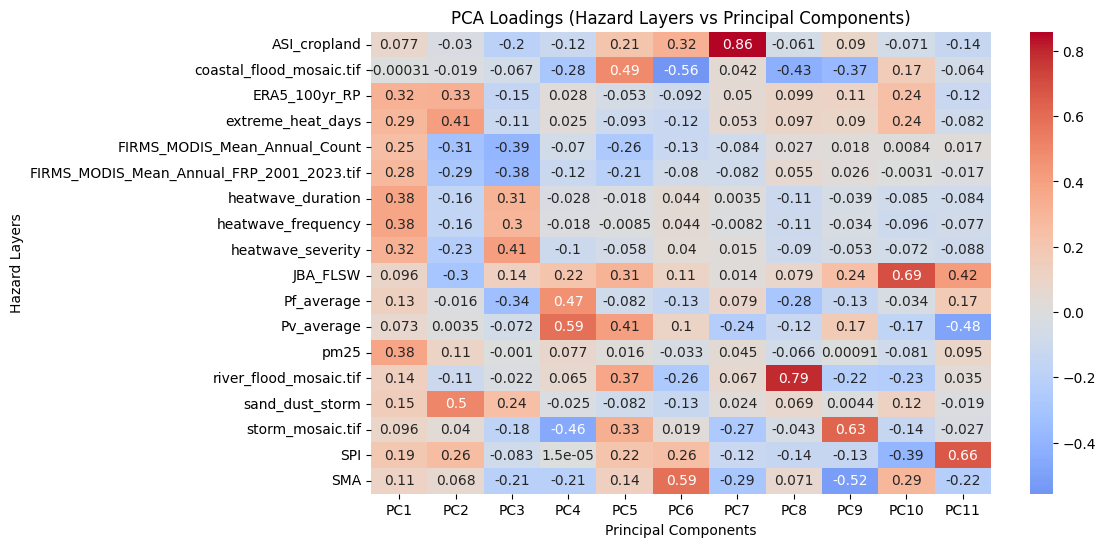

In [ ]:
# Get the PCA loadings (eigenvectors)
loadings = pca.components_

# Create a DataFrame to display the relationship between hazard layers and PCs
hazard_layers = [file.replace("_resampled.tif", "") for file in image_files]  # Clean names
loadings_df = pd.DataFrame(loadings.T, index=hazard_layers, columns=[f'PC{i+1}' for i in range(loadings.shape[0])])

# Sort and display the most influential layers for each PC
print(loadings_df)

# Plot the heatmap showing the relationship between hazard layers and principal components
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Loadings (Hazard Layers vs Principal Components)")
plt.xlabel("Principal Components")
plt.ylabel("Hazard Layers")
plt.show()

In [ ]:
layers = land_pixels_scaled.shape[1]
hazard_layers_arr = []  # Use list initialization

for i in range(layers):
    print(i)
    hazard_image = np.full_like(landsea_mask, np.nan, dtype=np.float32)
    hazard_image[land_mask] = land_pixels_scaled[:, i].flatten()
    hazard_layers_arr.append(hazard_image)  # Use append() instead of add()

# Define the folder where you want to save the multi-band image
output_path = "/content/drive/MyDrive/clustering_image/hazard_layers_multiband.tif"

# Stack the hazard layers into a multi-band array (each hazard layer is a band)
hazard_layers_stack = np.stack(hazard_layers_arr, axis=-1)

# Use the profile from an existing image to match metadata
with rasterio.open(os.path.join(image_folder, image_files[0])) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=hazard_layers_stack.shape[-1])  # Update the band count

# Write the multi-band image to a GeoTIFF
with rasterio.open(output_path, 'w', **profile) as dst:
    for i in range(hazard_layers_stack.shape[-1]):
        dst.write(hazard_layers_stack[:, :, i], i + 1)  # Write each band

print(f"Multi-band hazard layers exported to {output_path}")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
Multi-band hazard layers exported to /content/drive/MyDrive/clustering_image/hazard_layers_multiband.tif


In [ ]:
print(f"Min value of risk_sum: {np.min(risk_sum)}")
print(f"Max value of risk_sum: {np.max(risk_sum)}")

Min value of risk_sum: 0.0
Max value of risk_sum: 5.581412315368652


In [ ]:
print(f"Min value after scaling: {risk_sum_normalized.min()}")
print(f"Max value after scaling: {np.sum(risk_sum_normalized[risk_sum_normalized>=0.7])}")

Min value after scaling: 0.0
Max value after scaling: 2814.47119140625


In [ ]:
import numpy as np

# Assuming risk_sum_normalized is your array
mean_risk_sum = np.mean(risk_sum_normalized)
std_risk_sum = np.std(risk_sum_normalized)

# Calculate mean + 2 standard deviations and mean + 1 standard deviation
mean_plus_2sd = mean_risk_sum + 2 * std_risk_sum
mean_plus_1sd = mean_risk_sum + std_risk_sum

# Calculate specific percentiles
percentile_75 = np.percentile(risk_sum_normalized, 75)
percentile_90 = np.percentile(risk_sum_normalized, 90)
percentile_95 = np.percentile(risk_sum_normalized, 95)
percentile_99 = np.percentile(risk_sum_normalized, 99)

# Print the results
print(f"Mean of risk_sum_normalized: {mean_risk_sum}")
print(f"Mean + 1 Standard Deviation: {mean_plus_1sd}")
print(f"Mean + 2 Standard Deviations: {mean_plus_2sd}")
print(f"75th Percentile: {percentile_75}")
print(f"90th Percentile: {percentile_90}")
print(f"95th Percentile: {percentile_95}")
print(f"99th Percentile: {percentile_99}")


Mean of risk_sum_normalized: 0.32562756538391113
Mean + 1 Standard Deviation: 0.49461814761161804
Mean + 2 Standard Deviations: 0.663608729839325
75th Percentile: 0.4432218670845032
90th Percentile: 0.5403158962726593
95th Percentile: 0.5796858668327332
99th Percentile: 0.6493283420801161


In [ ]:
import numpy as np
import rasterio
from scipy.stats import gmean

# Calculate the geometric average across the bands for each pixel
# The land_pixels_scaled is a 2D array where rows are land pixels, and columns are bands

# Apply geometric mean across the bands (axis=1 represents the band dimension)
geometric_average = gmean(land_pixels_scaled, axis=1)

# Reshape the geometric average back to the original shape of the land-sea mask
geometric_average_image = np.zeros_like(landsea_mask, dtype=np.float32)
geometric_average_image[land_mask] = geometric_average

# Export the geometric average as a GeoTIFF
output_path = "/content/geometric_average.tif"

# Use the profile from an existing image to match metadata
with rasterio.open(os.path.join(image_folder, image_files[0])) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1)

# Write the result to a GeoTIFF
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(geometric_average_image, 1)

print(f"Geometric average image exported to {output_path}")


In [ ]:
import pandas as pd

# List of CSV filenames corresponding to the different thresholds
csv_files = [
    "/content/drive/MyDrive/Risk_Exposure_ByAOI_adm0_Mean.csv",
    "/content/drive/MyDrive/Risk_Exposure_ByAOI_adm0_MeanPlus1SD.csv",
    "/content/drive/MyDrive/Risk_Exposure_ByAOI_adm0_MeanPlus2SD.csv",
    "/content/drive/MyDrive/Risk_Exposure_ByAOI_adm0_Percentile75.csv",
    "/content/drive/MyDrive/Risk_Exposure_ByAOI_adm0_Percentile90.csv",
    "/content/drive/MyDrive/Risk_Exposure_ByAOI_adm0_Percentile95.csv",
    "/content/drive/MyDrive/Risk_Exposure_ByAOI_adm0_Percentile99.csv"
]

# Loop through each CSV file and compute the total exposed population
for csv_file in csv_files:
    df_exp = pd.read_csv(csv_file)
    total_exposed = df_exp['child_population_exposed'].sum()

    # Print the total exposed population for each threshold
    print(f"Total exposed population in {csv_file.split('/')[-1]}: {total_exposed}")


Total exposed population in Risk_Exposure_ByAOI_adm0_Mean.csv: 1858104029.139358
Total exposed population in Risk_Exposure_ByAOI_adm0_MeanPlus1SD.csv: 811696463.8367901
Total exposed population in Risk_Exposure_ByAOI_adm0_MeanPlus2SD.csv: 72040429.87219438
Total exposed population in Risk_Exposure_ByAOI_adm0_Percentile75.csv: 1213401250.2680993
Total exposed population in Risk_Exposure_ByAOI_adm0_Percentile90.csv: 522847747.2990949
Total exposed population in Risk_Exposure_ByAOI_adm0_Percentile95.csv: 264639434.26495135
Total exposed population in Risk_Exposure_ByAOI_adm0_Percentile99.csv: 72892719.63412817
